## Mount drive and import dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!ls /content/drive/MyDrive/Machine_Learning/Experiments/Twitter_Bots_Detection
!cp /content/drive/MyDrive/Machine_Learning/Experiments/Twitter_Bots_Detection/twitter_bots_train.csv ./

Mounted at /content/drive
twitter_bots_detection.ipynb  twitter_bots_og.ipynb	twitter_bots_train.csv
twitter_bots_krcz.ipynb       twitter_bots_train_2.csv


## Import libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import time
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.datasets import load_iris
from sklearn.tree import export_graphviz
import pydot
from sklearn.tree import plot_tree
!pip install umap-learn
import umap
from sklearn.metrics import roc_curve

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.7 MB/s eta 0:00:00


## Create dataset variable and list head

In [3]:
dataset = pd.read_csv('twitter_bots_train.csv')
dataset.head()

,Tweet,following,followers,actions,is_retweet,location,Type,Unnamed: 7
0,Good Morning Love @LeeBrown_V,0.0,0.0,0.0,0.0,"Pennsylvania, USA",Quality,NaN
1,'@realDonaldTrump @USNavy RIP TO HEROES',42096.0,61060.0,5001.0,0.0,"South Padre Island, Texas",Spam,NaN
2,Haven't been following the news but I understa...,0.0,0.0,NaN,0.0,Will never be broke ever again,Quality,NaN
3,pic.twitter.com/dy9q4ftLhZ What to do with pap...,0.0,0.0,0.0,0.0,Mundo,Quality,NaN
4,#DidYouKnow ► Mahatma Gandhi made a brief visi...,17800.0,35100.0,NaN,0.0,"Nottingham, England",Quality,NaN


## Preprocessing dataset

In [4]:
dataset['spam'] = np.where(dataset['Type'] == 'Spam', 1, 0)
dataset.drop(['Type', 'Unnamed: 7'], axis=1, inplace=True)
dataset.fillna(value=-1, inplace=True)
dataset.head()

,Tweet,following,followers,actions,is_retweet,location,spam
0,Good Morning Love @LeeBrown_V,0.0,0.0,0.0,0.0,"Pennsylvania, USA",0
1,'@realDonaldTrump @USNavy RIP TO HEROES',42096.0,61060.0,5001.0,0.0,"South Padre Island, Texas",1
2,Haven't been following the news but I understa...,0.0,0.0,-1.0,0.0,Will never be broke ever again,0
3,pic.twitter.com/dy9q4ftLhZ What to do with pap...,0.0,0.0,0.0,0.0,Mundo,0
4,#DidYouKnow ► Mahatma Gandhi made a brief visi...,17800.0,35100.0,-1.0,0.0,"Nottingham, England",0


## Checking balance in dataset

In [5]:
print('Normal Tweets percentage: {:.4f}%'.format(sum(dataset['spam']==0)/len(dataset['spam'])))
print('SPAM Tweets percentage: {:.4f}%'.format(sum(dataset['spam']==1)/len(dataset['spam'])))

Normal Tweets percentage: 0.5004%
SPAM Tweets percentage: 0.4996%


## Extract length, hashtags, mentions, digits, links and domains - Tokenization

In [6]:
def length(dataset):
    dataset['length'] = dataset['Tweet'].str.len()
    return dataset

def hashtags(dataset):
    dataset['hashtags'] = dataset['Tweet'].str.findall('\#\w+')
    dataset['hashtags_num'] = dataset['hashtags'].str.len()
    dataset['hashtags'] = dataset['hashtags'].str.join(' ')
    return dataset

def mentions(dataset):
    dataset['mentions'] = dataset['Tweet'].str.findall('\@\w+')
    dataset['mentions_num'] = dataset['mentions'].str.len()
    dataset['mentions'] = dataset['mentions'].str.join(' ')
    return dataset

def digits(dataset):
    dataset['digits'] = dataset['Tweet'].str.findall('\d+')
    dataset['digits_num'] = dataset['digits'].str.len()
    dataset['digits'] = dataset['digits'].str.join(' ')
    dataset['digits_length'] = dataset['digits'].str.len()

def links(dataset):
    dataset['links'] = dataset['Tweet'].str.findall('https?:\/\/\S+')
    dataset['links_num'] = dataset['links'].str.len()
    dataset['links'] = dataset['links'].str.join(' ')
    dataset['domains'] = dataset['links'].str.findall('\w+\.\w+')
    dataset['domains'] = dataset['domains'].str.join(' ')

length(dataset)
hashtags(dataset)
mentions(dataset)
digits(dataset)
links(dataset)

dataset.head()

,Tweet,following,followers,actions,is_retweet,location,spam,length,hashtags,hashtags_num,mentions,mentions_num,digits,digits_num,digits_length,links,links_num,domains
0,Good Morning Love @LeeBrown_V,0.0,0.0,0.0,0.0,"Pennsylvania, USA",0,30,,0,@LeeBrown_V,1,,0,0,,0,
1,'@realDonaldTrump @USNavy RIP TO HEROES',42096.0,61060.0,5001.0,0.0,"South Padre Island, Texas",1,40,,0,@realDonaldTrump @USNavy,2,,0,0,,0,
2,Haven't been following the news but I understa...,0.0,0.0,-1.0,0.0,Will never be broke ever again,0,82,#EFF,1,,0,,0,0,,0,
3,pic.twitter.com/dy9q4ftLhZ What to do with pap...,0.0,0.0,0.0,0.0,Mundo,0,149,#papercraft #diy,2,,0,9 4,2,3,http://paperlandmarks.com/product/the-partheno...,1,paperlandmarks.com
4,#DidYouKnow ► Mahatma Gandhi made a brief visi...,17800.0,35100.0,-1.0,0.0,"Nottingham, England",0,108,#DidYouKnow #Nottingham,2,@MumblingNerd,1,17 1931,2,7,,0,


## Split dataset into training and test data

In [7]:
X_train, X_test, y_train, y_test = train_test_split(dataset[['following', 'followers', 'actions', 'is_retweet', 'length', 'hashtags_num', 'mentions_num', 'digits_num', 'digits_length', 'links_num']], dataset['spam'], test_size=0.2, random_state=42)
X_train.head()

,following,followers,actions,is_retweet,length,hashtags_num,mentions_num,digits_num,digits_length,links_num
1891,0.0,14200000.0,-1.0,0.0,121,1,1,1,1,1
2996,5999.0,8435.0,10383.0,1.0,117,4,1,3,5,1
7341,0.0,0.0,16.0,0.0,40,0,0,0,0,0
12802,0.0,37300.0,12.0,0.0,94,0,0,1,18,1
4043,0.0,0.0,0.0,0.0,135,0,0,2,4,1


## Creating correlation matrix

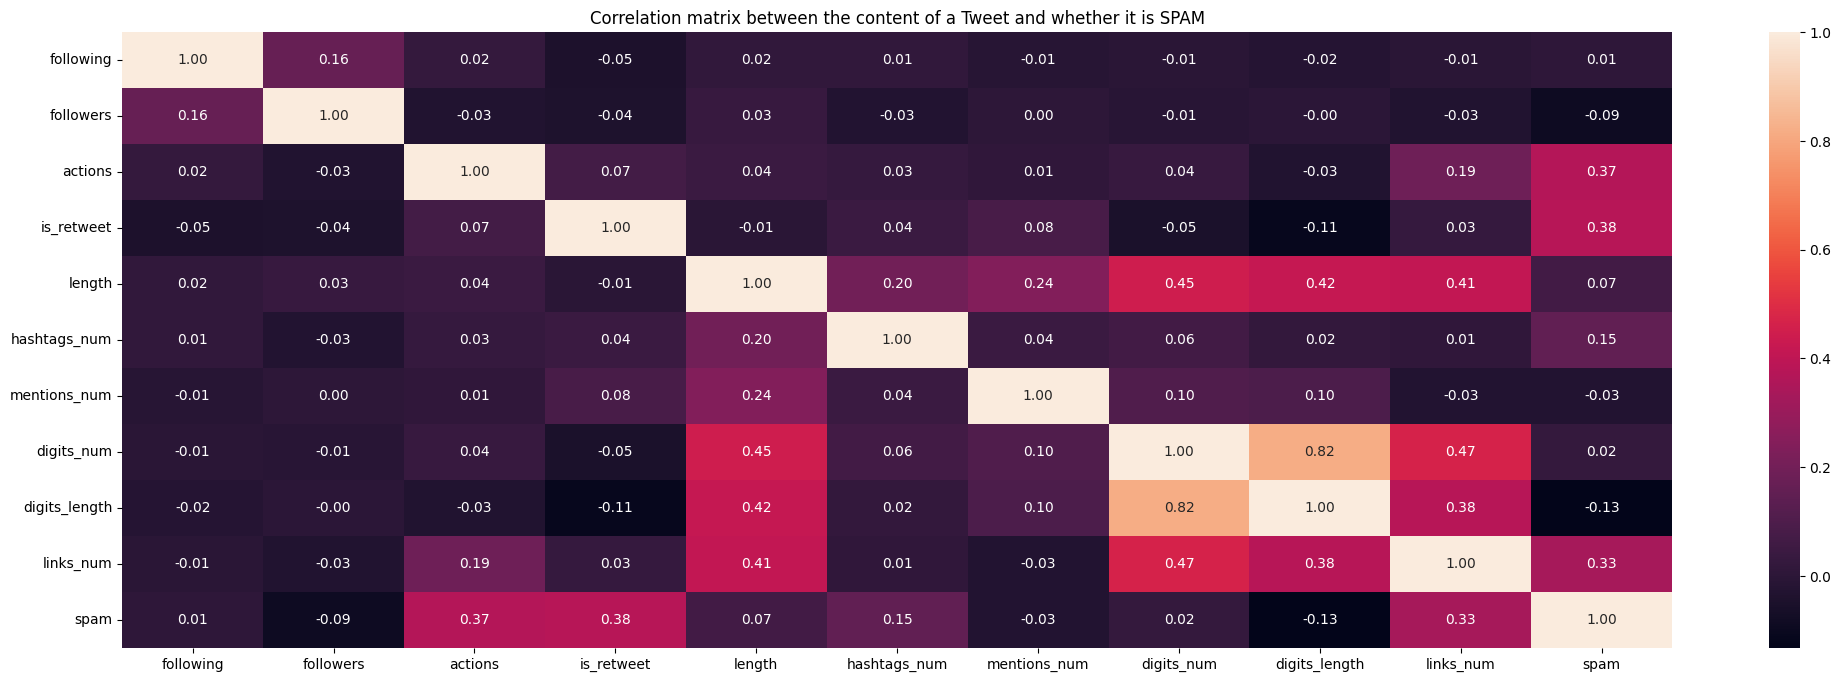

In [8]:
train_spam = X_train.copy()
train_spam['spam'] = y_train

plt.figure(figsize=(25,8))
sns.heatmap(train_spam[['following', 'followers', 'actions', 'is_retweet', 'length', 'hashtags_num', 'mentions_num', 'digits_num', 'digits_length', 'links_num', 'spam']].corr(), annot=True, fmt='.2f').set_title('Correlation matrix between the content of a Tweet and whether it is SPAM');

## Scale datasets

In [9]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Train models

In [10]:
def train(model):
  start = time.time()
  model.fit(X_train, y_train)
  end = time.time()
  print(model, '\n','Training time:', round((end - start), 3), 's\n')

models = [LogisticRegression(random_state = 0),
          KNeighborsClassifier(),
          SVC(kernel = 'linear', random_state = 0),
          SVC(random_state = 0),
          GaussianNB(),
          DecisionTreeClassifier(criterion = 'entropy', random_state = 0),
          RandomForestClassifier(criterion = 'entropy', random_state = 0)]

for model in models:
    train(model)

LogisticRegression(random_state=0) 
 Training time: 0.047 s

KNeighborsClassifier() 
 Training time: 0.032 s

SVC(kernel='linear', random_state=0) 
 Training time: 2.088 s

SVC(random_state=0) 
 Training time: 2.735 s

GaussianNB() 
 Training time: 0.011 s

DecisionTreeClassifier(criterion='entropy', random_state=0) 
 Training time: 0.046 s

RandomForestClassifier(criterion='entropy', random_state=0) 
 Training time: 1.524 s



## Prediction

In [11]:
def predict(model):
  start = time.time()
  y_pred = model.predict(X_test)
  end = time.time()
  predict_time = end - start
  accuracy = accuracy_score(y_test, y_pred)
  roc_auc = roc_auc_score(y_test, y_pred)
  print(model, '\n', 'Accuracy:', accuracy, '\n', 'ROC-AUC:', roc_auc, '\n', 'Time:', round(predict_time, 3), 's\n')

for model in models:
  predict(model)

LogisticRegression(random_state=0) 
 Accuracy: 0.9600671140939597 
 ROC-AUC: 0.9593644544431946 
 Time: 0.003 s

KNeighborsClassifier() 
 Accuracy: 0.9318791946308724 
 ROC-AUC: 0.9314989472469787 
 Time: 0.374 s

SVC(kernel='linear', random_state=0) 
 Accuracy: 0.9614093959731543 
 ROC-AUC: 0.9608146938363473 
 Time: 0.169 s

SVC(random_state=0) 
 Accuracy: 0.946979865771812 
 ROC-AUC: 0.9461248233393903 
 Time: 0.472 s

GaussianNB() 
 Accuracy: 0.6342281879194631 
 ROC-AUC: 0.6423731288396644 
 Time: 0.002 s

DecisionTreeClassifier(criterion='entropy', random_state=0) 
 Accuracy: 0.9969798657718121 
 ROC-AUC: 0.9970012762827724 
 Time: 0.001 s

RandomForestClassifier(criterion='entropy', random_state=0) 
 Accuracy: 0.9976510067114094 
 ROC-AUC: 0.9976114764500592 
 Time: 0.028 s



## Scores Without Scaler:

Prediction for Kernel SVC takes too much time with unscaled dataset. For this reason, it was excluded from the algorithms tested

    LogisticRegression(max_iter=2429, random_state=0)
     Accuracy: 0.9795302013422819 Time: 0.007 s

    KNeighborsClassifier()
     Accuracy: 0.987248322147651 Time: 0.207 s

    SVC(random_state=0)
     Accuracy: 0.5446308724832215 Time: 1.837 s

    GaussianNB()
     Accuracy: 0.5768456375838926 Time: 0.003 s

    DecisionTreeClassifier(criterion='entropy', random_state=0)
     Accuracy: 0.9969798657718121 Time: 0.005 s

    RandomForestClassifier(criterion='entropy', random_state=0)
     Accuracy: 0.9976510067114094 Time: 0.022 s

## Random Forest Classifier Score (Best)

In [12]:
rfc = RandomForestClassifier(criterion = 'entropy', random_state = 0)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
print(y_pred)

0.9976510067114094
[0 0 0 ... 1 0 0]


## Importance of features in RFC model predictions

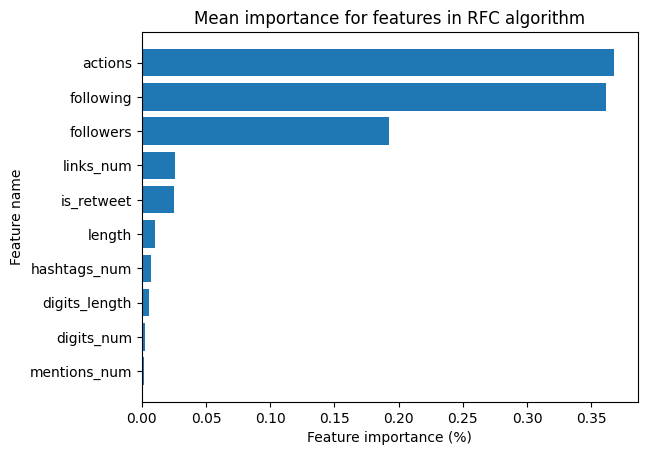

In [13]:
importances = rfc.feature_importances_
features = ['following', 'followers', 'actions', 'is_retweet', 'length', 'hashtags_num', 'mentions_num', 'digits_num', 'digits_length', 'links_num']
sort = np.argsort(importances)

plt.barh(range(len(importances)), importances[sort])
plt.yticks(range(len(importances)), [features[i] for i in sort])
plt.xlabel('Feature importance (%)')
plt.ylabel('Feature name')
plt.title('Mean importance for features in RFC algorithm')
plt.show()

## Individual Decision Tree Visualization

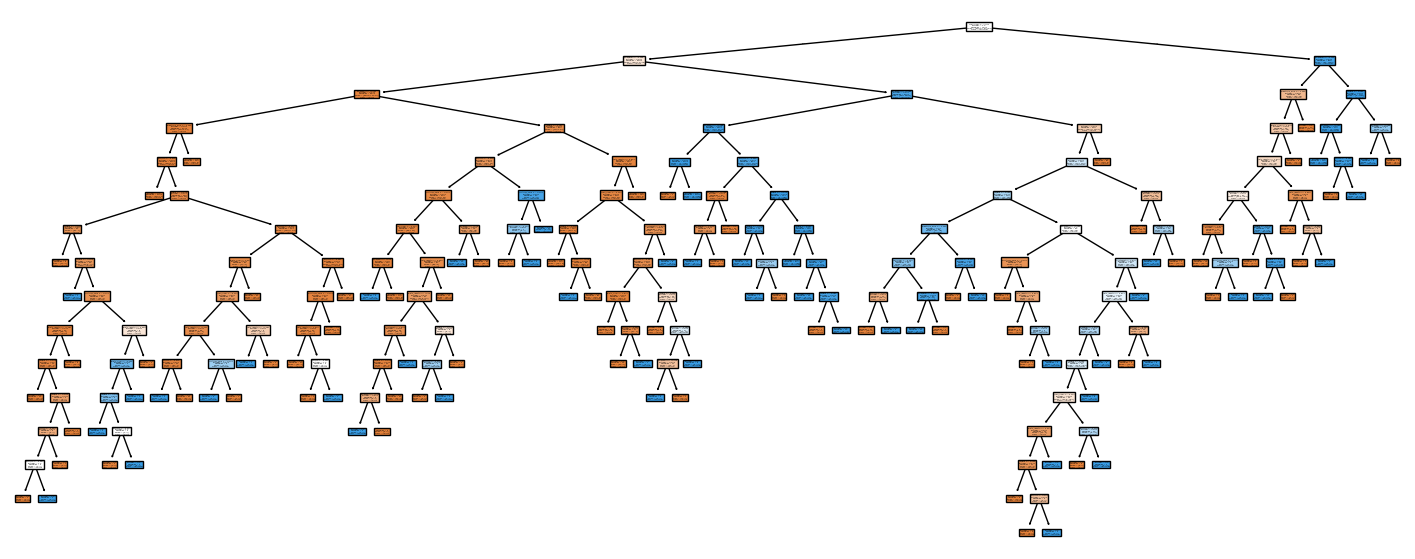

In [14]:
iris = load_iris()
tree = rfc.estimators_[0]

export_graphviz(tree, out_file='tree.dot', feature_names=features, class_names=iris.target_names, rounded=True, filled=True)
(graph,) = pydot.graph_from_dot_file('tree.dot')
graph.write_png('tree.png')

plt.figure(figsize=(18, 7))
plot_tree(tree, feature_names=features, class_names=iris.target_names, filled=True)
plt.show()

## UMAP Visualization for Best Score

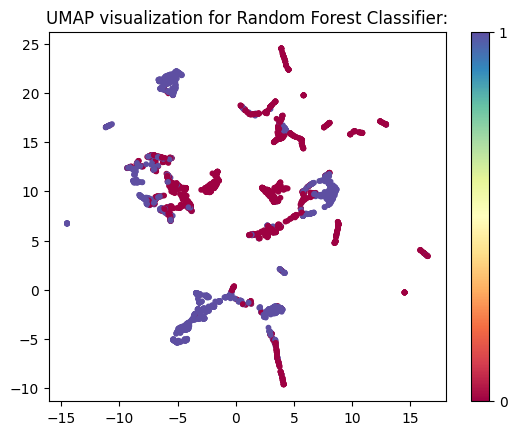

In [15]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(X_test)
plt.scatter(embedding[:, 0], embedding[:, 1], c=y_pred, cmap='Spectral', s=10)
plt.title('UMAP visualization for Random Forest Classifier:')
plt.colorbar(ticks=[0, 1])
plt.show()

##ROC Curve for Best Score

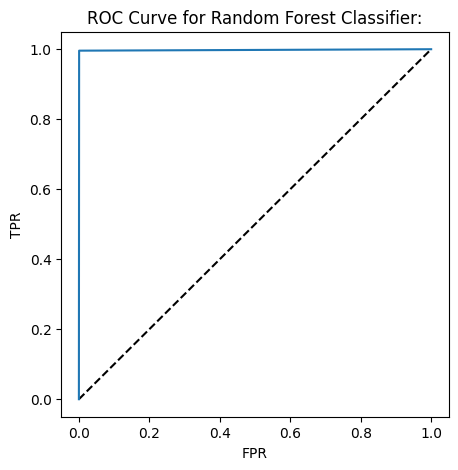

In [16]:
plt.figure(figsize = (5, 5))
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label = "RFC")
plt.title('ROC Curve for Random Forest Classifier:')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()